In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [14]:
def logistic(x):
    return 1 / (1 + np.exp(-x))
def _sigmoid(x, x0, k, ylo, yhi):
    height_diff = yhi - ylo
    return ylo + height_diff * logistic(k * (x - x0))
def _sig_slope(x, xtp, ytp, x0, slope_k, lo, hi):
    slope = _sigmoid(x, x0, slope_k, lo, hi)
    return ytp + slope * (x - xtp)

def _returned_mass(lg_age_yr, a, b, lgk1, d, e, f, lgk2, h):
    k1 = 10**lgk1
    xtp = b
    z = _sig_slope(lg_age_yr, xtp, a, b, k1, d, e)

    k2 = 10**lgk2
    h = _sigmoid(lg_age_yr, f, k2, h, z)
    return h

def surviving_mstar(
    lg_age_yr,
    a=DEFAULT_PARAMS["a"],
    b=DEFAULT_PARAMS["b"],
    lgk1=DEFAULT_PARAMS["lgk1"],
    d=DEFAULT_PARAMS["d"],
    e=DEFAULT_PARAMS["e"],
    f=DEFAULT_PARAMS["f"],
    lgk2=DEFAULT_PARAMS["lgk2"],
    h=DEFAULT_PARAMS["h"],
):
    """Calculate the fraction of stellar mass that survives as a population ages.

    Default behavior assumes Chabrier IMF.
    Calibrations for the following alternative parameters are also available:
        SALPETER_PARAMS, KROUPA_PARAMS, VAN_DOKKUM_PARAMS

    Parameters
    ----------
    lg_age_yr : ndarray of shape (n, )
        Base-10 log of the age of the stellar population in years

    Returns
    -------
    frac_surviving : ndarray of shape (n, )
        Surviving fraction

    """
    frac_returned = _returned_mass(lg_age_yr, a, b, lgk1, d, e, f, lgk2, h)
    return 1 - frac_returned

In [32]:
from collections import OrderedDict
from copy import deepcopy

PARAMS = OrderedDict(x0=2, yhi=0.58)
DEFAULT_PARAMS = OrderedDict(
    a=0.225,
    b=8.0,
    lgk1=-0.5,
    d=0.145,
    e=0.08,
    f=6.5,
    lgk2=0.7,
    h=0.005,
)
SALPETER_PARAMS = deepcopy(DEFAULT_PARAMS)
CHABRIER_PARAMS = deepcopy(DEFAULT_PARAMS)
KROUPA_PARAMS = deepcopy(DEFAULT_PARAMS)
VAN_DOKKUM_PARAMS = deepcopy(DEFAULT_PARAMS)

SALPETER_PARAMS.update(a=0.13, d=0.055)
CHABRIER_PARAMS.update(a=0.225, d=0.145)
KROUPA_PARAMS.update(a=0.211, d=0.13)
VAN_DOKKUM_PARAMS.update(a=0.238, d=0.156)

In [35]:
lg_age_yr = np.linspace(5.5, 9.5, 100)

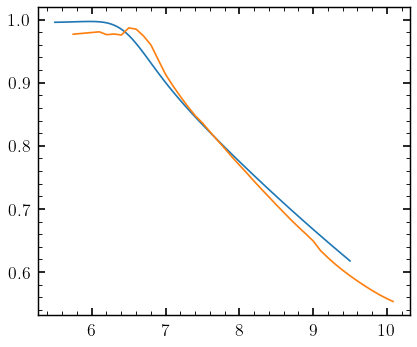

In [52]:
plt.plot(lg_age_yr, surviving_mstar(lg_age_yr))

plt.plot(np.log10(np.array(age) * 1e9), fsurv)

In [ ]:
def surviving_stellar_mass(self, tt, zred=None, tage=None):
    ''' given a set of parameter values `tt` and redshift `zred`, 
    calculate the surviving stellar mass. 

    parameters
    ----------
    tt : array_like[Ntheta, Nparam]
       Parameter values of [log M*, b1SFH, b2SFH, b3SFH, b4SFH, g1ZH, g2ZH,
       'dust1', 'dust2', 'dust_index']. 

    zred : float 
        redshift

    tage : float 
        age of galaxy, in Gyr

    '''
    if zred is None and tage is None:
        raise ValueError('specify either zred or tage')
    if zred is not None and tage is not None:
        raise ValueError('specify either zred or tage')
    if tage is None:
        assert isinstance(zred, float)
        tage = self.cosmo.age(zred).value  # age in Gyr

    theta = self._parse_theta(tt)

    # sfh nmf basis coefficients
    tt_sfh = np.array([theta['beta1_sfh'], theta['beta2_sfh'],
                       theta['beta3_sfh'], theta['beta4_sfh']]).T

    # log-spaced lookback time bin edges
    tlb_edges = utils.tlookback_bin_edges(tage)

    sfh_basis_tlb = np.array([
        utils.trapz_rebin(self._t_lb_hr, _sfh_basis, edges=tlb_edges)
        for _sfh_basis in self._sfh_basis_hr])

    sfh = np.sum(np.array([tt_sfh[:, i][:, None] *
                           sfh_basis_tlb[i][None, :] for i in range(self._N_nmf_sfh)]),
                 axis=0)
    
    
    tages = 0.5 * (tlb_edges[1:] + tlb_edges[:-1])  # ages of SSP
    dt = np.diff(tlb_edges)  # bin widths
    
    Msurv = 0
    # look over log-spaced lookback time bins and add up SSPs
    for i, tage in enumerate(tages):
        m = 1e9 * dt[i] * sfh[i]  # mass formed in this bin
        print(m)
        if m == 0 and i != 0:
            continue
        Msurv += m * surviving_mstar(np.log10(tage * 1e9))
    
    # add starburst event
    if self._burst:
        # fraction of stellar mass from star burst
        fburst = theta['fburst']
        tburst = theta['tburst']  # time of star burst

        noburst = (tburst > tage)
        fburst[noburst] = 0.
        Msurv *= (1. - fburst)

        burst_dt = (tburst < dt)
        Msurv[burst_dt] += theta['fburst'][burst_dt]

    # multiply by stellar mass
    avg_sfr = Mform * 10**theta['logmstar'] / dt / 1e9
    return avg_sfr


In [18]:
from popsed.utils import surviving_mstar

In [23]:
from popsed.models import NMF
model = NMF(burst=True, peraa=True)
model._ssp_initiate()
model._ssp.params['add_stellar_remnants'] = False

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


In [20]:
model._ssp.params['add_stellar_remnants'] = True

In [24]:
lg_age_yr = np.linspace(5.5, 9.5, 100)
fsurv = []
for age in lg_age_yr:
    tage = 10**(age - 9)
    model._ssp.get_spectrum(tage=tage, peraa=True)
    fsurv.append(model._ssp.stellar_mass)

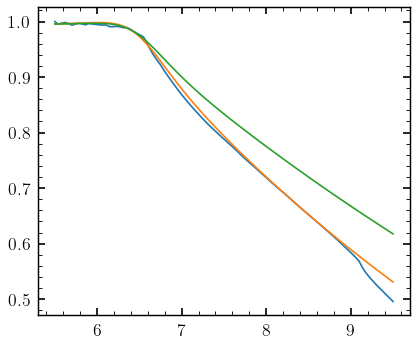

In [37]:
plt.plot(lg_age_yr, fsurv)
plt.plot(lg_age_yr, surviving_mstar(lg_age_yr, a=0.28, d=0.2))

In [ ]:
sp.params["imf_type"] = 1

In [11]:
model._ssp.get_spectrum(tage=11, peraa=True)

(array([1.00000000e+02, 1.00200200e+02, 1.00400801e+02, ...,
        9.75435116e+07, 9.85238402e+07, 9.95140213e+07]),
 array([7.61004485e-10, 6.77905159e-10, 1.02483266e-09, ...,
        1.96006364e-20, 1.88302435e-20, 1.28499423e-20]))

In [13]:
model._ssp.stellar_mass

0.4151445265436164

In [38]:
tt = np.array([ 1.09182625e+01,  2.17854857e-01,  5.83481967e-01,  2.86570005e-03,
        1.95797443e-01,  1.10937208e-01,  9.90190792e+00, -9.90409374e-01,
        1.63689405e-01,  7.10925341e-01, -6.09095097e-02])

In [42]:
model.survMass(tt, zred=0.0)

10.695174885298789

In [59]:
tlb_edges, sfh = model.SFH(tt, zred=0.05, _burst=True) # Mstar / yr
tages = 0.5 * (tlb_edges[1:] + tlb_edges[:-1])  # ages of SSP
dt = np.diff(tlb_edges)  # bin widths

Msurv = 0
# look over log-spaced lookback time bins and add up SSPs
for i, tage in enumerate(tages):
    m = 1e9 * dt[i] * sfh[i]  # mass formed in this bin
    if m == 0 and i != 0:
        continue
    Msurv += m * surviving_mstar(np.log10(tage * 1e9))
    
return np.log10(Msurv)

In [66]:
np.log10(Msurv)

10.695252396028927

In [67]:
model._parse_theta(tt)

{'logmstar': array([10.9182625]),
 'beta1_sfh': array([0.21785486]),
 'beta2_sfh': array([0.58348197]),
 'beta3_sfh': array([0.0028657]),
 'beta4_sfh': array([0.19579744]),
 'fburst': array([0.11093721]),
 'tburst': array([9.90190792]),
 'logzsol': array([-0.99040937]),
 'dust1': array([0.16368941]),
 'dust2': array([0.71092534]),
 'dust_index': array([-0.06090951])}

In [46]:
age = [5.61009227e-04, 1.26727800e-03, 1.59540848e-03, 2.00850027e-03
, 2.52855203e-03, 3.18325841e-03, 4.00748491e-03, 5.04512459e-03
, 6.35143555e-03, 7.99598361e-03, 1.00663470e-02, 1.26727800e-02
, 1.59540848e-02, 2.00850027e-02, 2.52855203e-02, 3.18325841e-02
, 4.00748491e-02, 5.04512459e-02, 6.35143555e-02, 7.99598361e-02
, 1.00663470e-01, 1.26727800e-01, 1.59540848e-01, 2.00850027e-01
, 2.52855203e-01, 3.18325841e-01, 4.00748491e-01, 5.04512459e-01
, 6.35143555e-01, 7.99598361e-01, 1.00663470e+00, 1.26727800e+00
, 1.59540848e+00, 2.00850027e+00, 2.52855203e+00, 3.18325841e+00
, 4.00748491e+00, 5.04512459e+00, 6.35143555e+00, 7.99598361e+00
, 1.00663470e+01, 1.21100923e+01]

In [47]:
fsurv = [0.9767513044924316, 0.9805040678578714, 0.9759969472564719, 0.9770231508925826, 0.9755087446526843, 0.9868141502113658, 0.9846628505469607, 0.9737796732325235, 0.9595799980878585, 0.9358699647862443, 0.9125541940788376, 0.8945065758494374, 0.8778391659075865, 0.8620301462766773, 0.8475905886540275, 0.835875380234915, 0.8220601485203657, 0.80873761047119, 0.7955649096010288, 0.7819693848151471, 0.7691975652934832, 0.7565636119116655, 0.7435396054257593, 0.7308958115055518, 0.7187487808174136, 0.7062601194697075, 0.6942579895915726, 0.6823415937137849, 0.6710768583087555, 0.6601698492180192, 0.6489545230983942, 0.6336507991328242, 0.6224513492030951, 0.6120913879717773, 0.6025932391888428, 0.5938387458404316, 0.5856174763769273, 0.5778115235115081, 0.570494225200711, 0.5637171993176122, 0.5576562063298548, 0.5533068058528564]